In [1]:
import pandas as pd
import numpy as np
#df = pd.read_csv("saved/5m_conf_cs_preprocessed_text.csv", index_col=0)
df = pd.read_csv("saved/final_dataset_cs_papers_last_20.csv", index_col="PaperId")

In [2]:
df.columns.tolist()

['Abstract',
 'Author_1',
 'Author_10',
 'Author_11',
 'Author_2',
 'Author_3',
 'Author_4',
 'Author_5',
 'Author_6',
 'Author_7',
 'Author_8',
 'Author_9',
 'CitationCount',
 'CitationCountPerYear',
 'FieldOfStudy_0',
 'FieldOfStudy_1',
 'FieldOfStudy_2',
 'FieldOfStudy_3',
 'FieldOfStudy_4',
 'FieldOfStudy_5',
 'FirstPage',
 'JournalName',
 'LastPage',
 'PublishedDate',
 'Publisher',
 'Rank',
 'Title',
 'YearsSincePublication',
 'AuthorProminence',
 'MagBin',
 'CitationBin',
 'AuthorRank',
 'JournalNameRank',
 'PublisherRank',
 'PageCount',
 'Processed_Abstract',
 'JournalNameRankNormalized',
 'PublisherRankNormalized']

## Bin citations per top/bot theta %

In [3]:
def bin_citation(citation_counts, theta):
    theta_num = int(theta*len(citation_counts))
    sort_counts = df.CitationCountPerYear.sort_values(ascending=False)
    bins = sort_counts.copy()
    bins[:] = -1
    bins[0:theta_num] = 1
    bins[bins.size-theta_num-1:] = 0
    return bins, theta_num

In [4]:
bins, theta_num = bin_citation(df.CitationCountPerYear, 0.02)

In [5]:
df["bin"] = bins

In [6]:
np.unique(df.bin, return_counts=True)

(array([-1.,  0.,  1.]), array([58578,  1221,  1220]))

## GMM

In [7]:
cc = df["CitationCountPerYear"].values

In [8]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4, random_state=0)
gmm.fit(cc.reshape(-1,1))
gmm.means_

array([[ 0.17034089],
       [49.67828457],
       [ 6.83178226],
       [ 1.1702358 ]])

In [9]:
gmm.predict(cc.reshape(-1, 1))

array([0, 2, 0, ..., 2, 0, 0])

In [10]:
df["citation_bin"] = gmm.predict(cc.reshape(-1, 1))

In [11]:
np.unique(df.citation_bin, return_counts=True)

(array([0, 1, 2, 3]), array([28084,  1209,  9935, 21791]))

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def correlation(df, columns=None, plot=True):
    t = df[columns] if columns else df
    if not plot:
        print(t.corr())
    else:
        fig = plt.figure()
        mask = np.triu(t.corr())
        sns.heatmap(
            t.corr(),
            mask=mask,
            cbar=False,
            square=True,
            annot=True,
            vmin=-1,
            vmax=1,
            center=0,
            cmap="coolwarm_r",
            linecolor="black",
        )
        plt.show()

In [13]:
df.columns

Index(['Abstract', 'Author_1', 'Author_10', 'Author_11', 'Author_2',
       'Author_3', 'Author_4', 'Author_5', 'Author_6', 'Author_7', 'Author_8',
       'Author_9', 'CitationCount', 'CitationCountPerYear', 'FieldOfStudy_0',
       'FieldOfStudy_1', 'FieldOfStudy_2', 'FieldOfStudy_3', 'FieldOfStudy_4',
       'FieldOfStudy_5', 'FirstPage', 'JournalName', 'LastPage',
       'PublishedDate', 'Publisher', 'Rank', 'Title', 'YearsSincePublication',
       'AuthorProminence', 'MagBin', 'CitationBin', 'AuthorRank',
       'JournalNameRank', 'PublisherRank', 'PageCount', 'Processed_Abstract',
       'JournalNameRankNormalized', 'PublisherRankNormalized', 'bin',
       'citation_bin'],
      dtype='object')

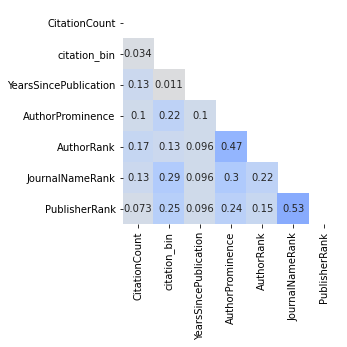

In [14]:
correlation(df, columns=[
    "CitationCount",
    "citation_bin",
    "YearsSincePublication",
    "AuthorProminence",
    "AuthorRank",
    "JournalNameRank",
    "PublisherRank"
])

## Train some models based on bin

In [15]:
# Remove rows not in top/bot %
dfs = []
min_size = np.inf
for i in np.unique(df.bin):
    if i != -1:
        dfs.append(df[df.bin == i])
        min_size = dfs[-1].shape[0] if dfs[-1].shape[0] < min_size else min_size
dfs = [d.sample(frac=1).iloc[:min_size] for d in dfs]
df_c = pd.concat(dfs)
df_c = df_c.sample(frac=1).reset_index(drop=True)

In [16]:
np.unique(df_c.bin, return_counts=True)

(array([0., 1.]), array([1220, 1220]))

In [17]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_c[
        [
            "YearsSincePublication",
            "AuthorProminence",
            "AuthorRank",
            "JournalNameRank", 
            "PublisherRank"
        ]
    ],
    df_c.bin)

In [18]:
from sklearn.metrics import classification_report
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [19]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84       306
         1.0       0.82      0.88      0.85       304

    accuracy                           0.84       610
   macro avg       0.84      0.84      0.84       610
weighted avg       0.84      0.84      0.84       610



In [20]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_test)
print(classification_report(y_test, xg_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.84      0.86       306
         1.0       0.85      0.89      0.87       304

    accuracy                           0.87       610
   macro avg       0.87      0.87      0.87       610
weighted avg       0.87      0.87      0.87       610



## Custom Corpus

In [21]:
cs_corpus = open("data_tools/cs_lexicon.txt", "r").read()
cs_corpus = set(cs_corpus.split("\n"))

In [22]:
def filter_cs(string):
    tokens = string.split(" ")
    tokens = filter(lambda x: x in cs_corpus, tokens)
    return " ".join(list(tokens))

In [23]:
df_c["cs_corpus_text"] = pd.Series([filter_cs(x) for x in df_c.Processed_Abstract])

In [24]:
df_c.cs_corpus_text

0       web security privacy online security privacy w...
1                                network tolerant network
2                interface neural application application
3       thermal profile chip thermal thermal process c...
4       wireless broadband cellular cellular spatial o...
                              ...                        
2435    smart grid novel algorithm quadratic convex to...
2436                         software dependency software
2437    process hardware software remote software veri...
2438                      cellular accelerate application
2439    cognitive histogram texture naive linear neura...
Name: cs_corpus_text, Length: 2440, dtype: object

In [25]:
def vectorize_text(df, text_col, vectorizer):
    vectorized = vectorizer.fit_transform(df[text_col])
    vectorized_df = pd.DataFrame.sparse.from_spmatrix(
        vectorized, columns=vectorizer.get_feature_names(), index=df.index
    )

    return vectorized_df, vectorizer

## Bag of Words

In [170]:
from sklearn.feature_extraction.text import CountVectorizer
# df_bow, vectorizer = vectorize_text(
#         df_c, "cs_corpus_text", CountVectorizer(min_df=0)
#     )
df_bow, vectorizer = vectorize_text(
        df_c, "Processed_Abstract", CountVectorizer(min_df=0.1, max_df=0.5)
    )

In [171]:
df_bow

,achieve,algorithm,analysis,application,apply,approach,article,available,base,challenge,...,technique,technology,test,this,time,to,tool,user,we,work
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,2,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,0,1,0,...,2,1,0,1,2,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2435,0,2,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2436,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2437,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,2,0,1
2438,0,0,0,1,0,0,0,0,0,2,...,0,0,0,0,0,1,0,0,1,0


In [158]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(df_bow)

Text(0.5, 1.0, 'UMAP projection Bag-of-Words')

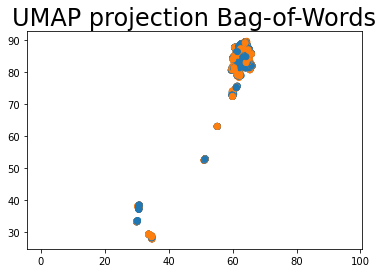

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[int(x)] for x in df_c.bin]
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection Bag-of-Words', fontsize=24)

In [161]:
df_text = pd.merge(df_c[
        [
            "YearsSincePublication",
            "AuthorProminence",
            "AuthorRank",
            "JournalNameRank", 
            "PublisherRank"
        ]
    ], df_bow, left_index=True, right_index=True)

BoW + Other Features

In [164]:
X_train, X_test, y_train, y_test = train_test_split(
    df_text,
    df_c.bin)

In [165]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88       296
         1.0       0.89      0.88      0.89       314

    accuracy                           0.89       610
   macro avg       0.89      0.89      0.89       610
weighted avg       0.89      0.89      0.89       610



Only BoW

In [166]:
X_train, X_test, y_train, y_test = train_test_split(
    df_bow,
    df_c.bin)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

         0.0       0.58      0.67      0.63       314
         1.0       0.59      0.49      0.54       296

    accuracy                           0.59       610
   macro avg       0.59      0.58      0.58       610
weighted avg       0.59      0.59      0.58       610



In [167]:
list(df_bow.columns)

['address',
 'allow',
 'analyze',
 'area',
 'case',
 'computer',
 'efficient',
 'evaluate',
 'field',
 'focus',
 'framework',
 'function',
 'identify',
 'implement',
 'key',
 'low',
 'multiple',
 'novel',
 'power',
 'quality',
 'rate',
 'real',
 'reduce',
 'relate',
 'review',
 'service',
 'source',
 'state',
 'task',
 'term',
 'type',
 'way']